# EDA
El objetivo de este notebook es realizar un análisis explorativo de datos, y usar este análisis para limpiar más los datos y/o preprocesarlos

In [17]:
from src.data_processing import standardize_features
%load_ext autoreload
%autoreload 2

import pandas as pd

from src.utils import DEV_SET_CLEAN_PATH, TARGET
from src.plots import plot_boolean_impact, plot_correlation_heatmap, plot_histograms, plot_boxplots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
df = pd.read_csv("../" + DEV_SET_CLEAN_PATH)

In [7]:
df.describe(include="all")

,id_grid,STotalM2,SConstrM2,Dormitorios,Banos,Ambientes,Amoblado,Antiguedad,BusinessCenter,Gimnasio,...,ITE_ADD_STATE_NAME,ITE_ADD_NEIGHBORHOOD_NAME,ITE_TIPO_PROD,LONGITUDE,LATITUDE,precio_pesos_constantes,year,SUM,meses_desde_comienzo,mes_listing
count,270715.000000,2.625630e+05,2.637050e+05,270593.000000,270713.000000,269365.000000,240403,2.462150e+05,203480,238431,...,270715,258095,270715,270715.000000,270715.000000,2.707150e+05,270715.000000,214480,270715.000000,270715.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2,2,...,4,503,3,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,...,Capital Federal,Palermo,U,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,220227,NaN,202323,209818,...,153869,15541,198204,NaN,NaN,NaN,NaN,176426,NaN,NaN
mean,59783.357649,3.966948e+03,1.720614e+03,1.415528,1.335315,2.402862,NaN,2.907292e+01,NaN,NaN,...,NaN,NaN,NaN,-58.481007,-34.598213,8.215410e+04,2021.472172,NaN,11.152702,6.521190
std,14743.238038,9.779880e+05,4.121375e+05,1.025419,1.030387,1.391798,NaN,4.419469e+03,NaN,NaN,...,NaN,NaN,NaN,0.115097,0.081543,6.757349e+05,0.499226,NaN,6.845461,3.439394
min,124.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,1.000000,NaN,0.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.874595,-34.923504,4.264038e+01,2021.000000,NaN,0.000000,1.000000
25%,53517.000000,3.900000e+01,3.700000e+01,1.000000,1.000000,2.000000,NaN,0.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.543363,-34.632289,6.568300e+03,2021.000000,NaN,4.960578,4.000000
50%,60080.000000,5.000000e+01,4.600000e+01,1.000000,1.000000,2.000000,NaN,7.000000e+00,NaN,NaN,...,NaN,NaN,NaN,-58.449924,-34.597885,9.166979e+03,2021.000000,NaN,10.972405,7.000000
75%,65657.000000,7.800000e+01,7.000000e+01,2.000000,1.000000,3.000000,NaN,3.000000e+01,NaN,NaN,...,NaN,NaN,NaN,-58.400915,-34.566651,1.866683e+04,2022.000000,NaN,16.951380,9.000000


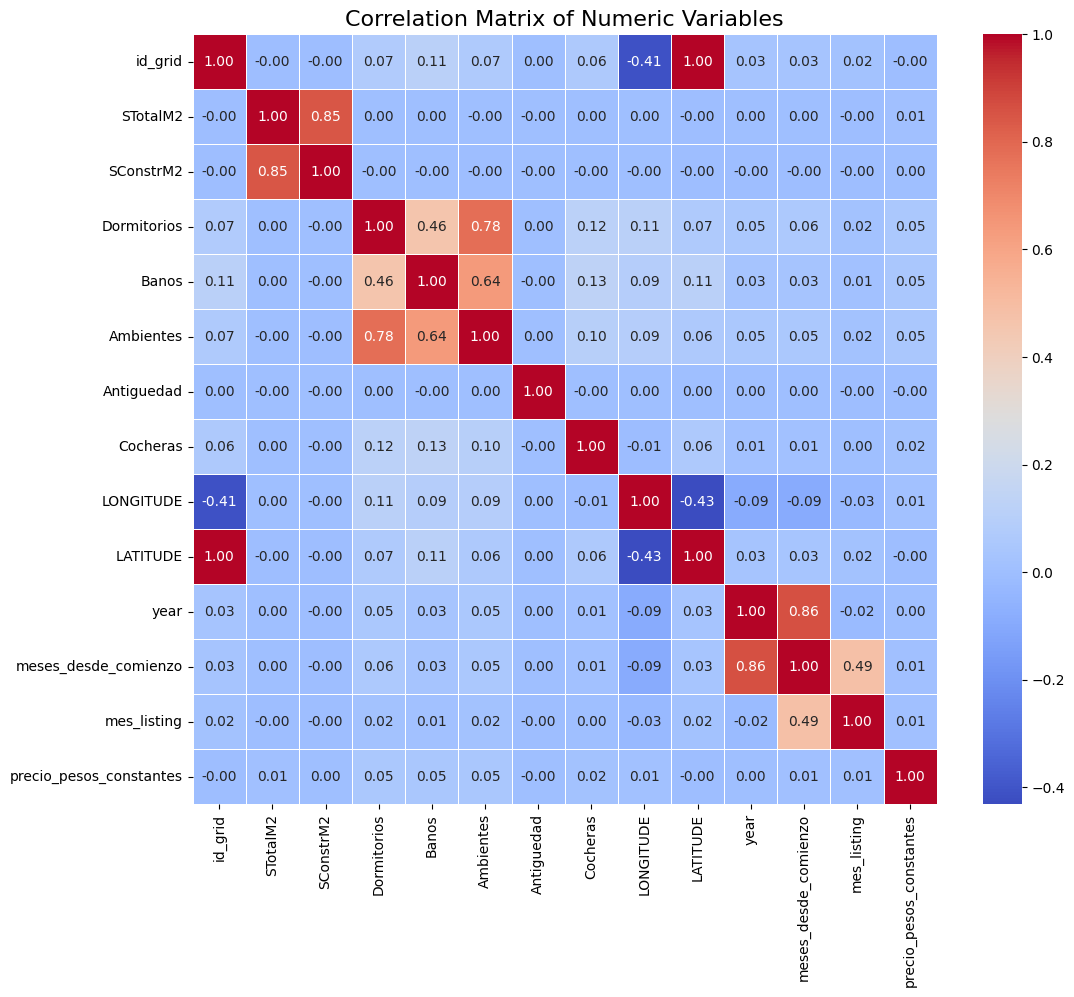

In [9]:
NUMERIC_COLS = ["id_grid", "STotalM2", "SConstrM2", "Dormitorios", "Banos", "Ambientes", "Antiguedad", "Cocheras", "LONGITUDE", "LATITUDE", "year", "meses_desde_comienzo", "mes_listing", TARGET]

plot_correlation_heatmap(df, NUMERIC_COLS)

A excepción de un par de columnas, la correlación es bajísima. Esto puede deberse a las grandes diferencias entre columnas. También es probable que haya

In [14]:
df_std, params_df_std = standardize_features(df, NUMERIC_COLS[:-1])

Standardizing columns: id_grid, STotalM2, SConstrM2, Dormitorios, Banos, Ambientes, Antiguedad, Cocheras, LONGITUDE, LATITUDE, year, meses_desde_comienzo, mes_listing


In [15]:
df_std.head()

,id_grid,STotalM2,SConstrM2,Dormitorios,Banos,Ambientes,Amoblado,Antiguedad,BusinessCenter,Gimnasio,...,ITE_ADD_STATE_NAME,ITE_ADD_NEIGHBORHOOD_NAME,ITE_TIPO_PROD,LONGITUDE,LATITUDE,precio_pesos_constantes,year,SUM,meses_desde_comienzo,mes_listing
0,-0.028580,-0.004016,-0.004088,-0.405227,-0.325426,-0.289455,False,-0.006578,False,False,...,Bs.As. G.B.A. Oeste,Caseros,N,-0.739700,-0.013327,6.279294e+03,1.057293,False,1.139824,0.429962
1,0.576783,-0.004008,-0.004078,-0.405227,-0.325426,-0.289455,False,-0.004994,False,False,...,Capital Federal,Núñez,U,0.063416,0.569677,1.092339e+04,-0.945808,False,-1.197299,-0.733033
2,-0.000635,-0.003925,-0.004022,-0.405227,-0.325426,0.429040,False,0.002472,False,False,...,Capital Federal,NaN,U,0.832954,-0.018061,1.081992e+04,-0.945808,False,-0.463049,0.720711
3,0.177617,-0.003610,-0.003117,0.569983,1.615593,4.021515,NaN,0.004735,NaN,False,...,Capital Federal,Recoleta,U,0.759267,0.160052,1.230069e+05,1.057293,NaN,1.581334,1.302209
4,-0.134255,-0.003749,-0.003447,0.569983,2.586102,2.584525,False,-0.006578,False,False,...,Capital Federal,Monserrat,U,0.907183,-0.151943,7.714647e+06,-0.945808,False,-1.197299,-0.733033


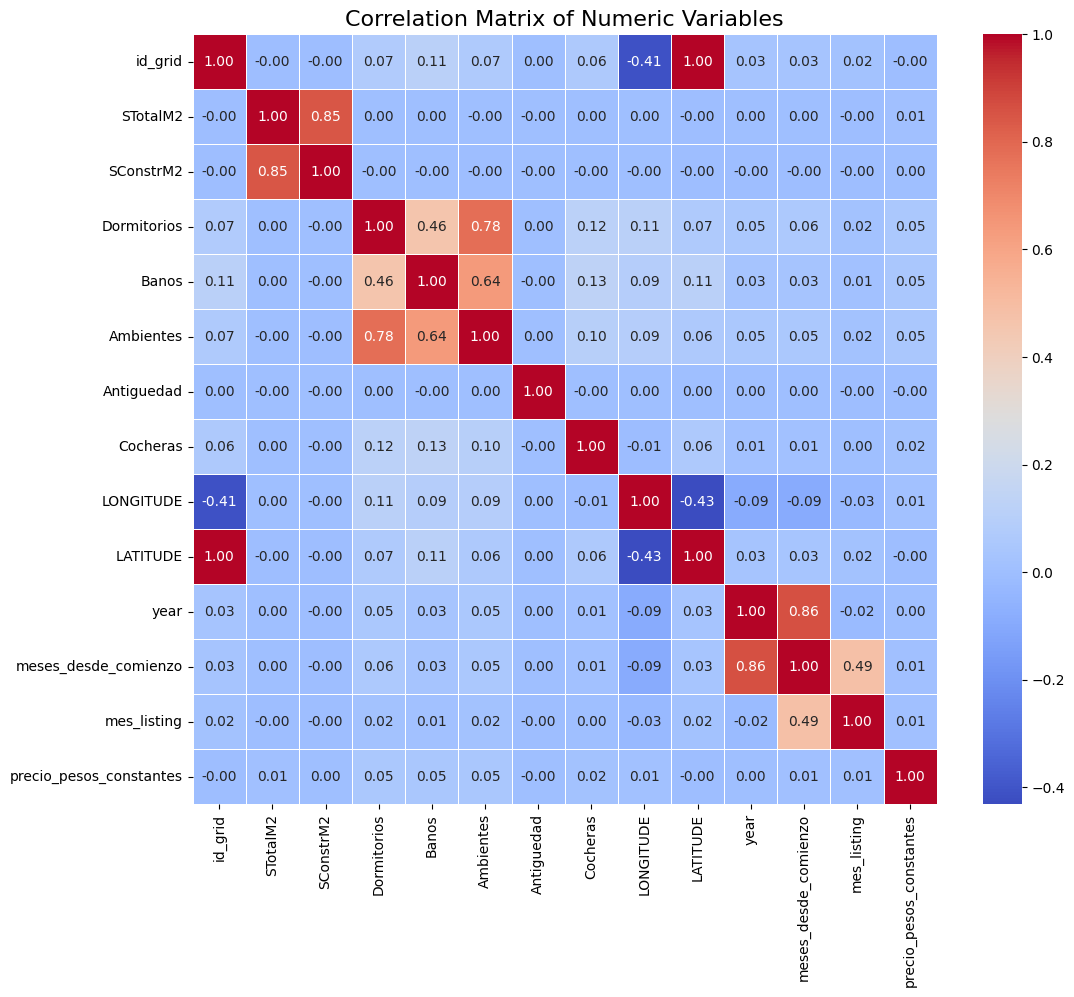

In [16]:
plot_correlation_heatmap(df_std, NUMERIC_COLS)

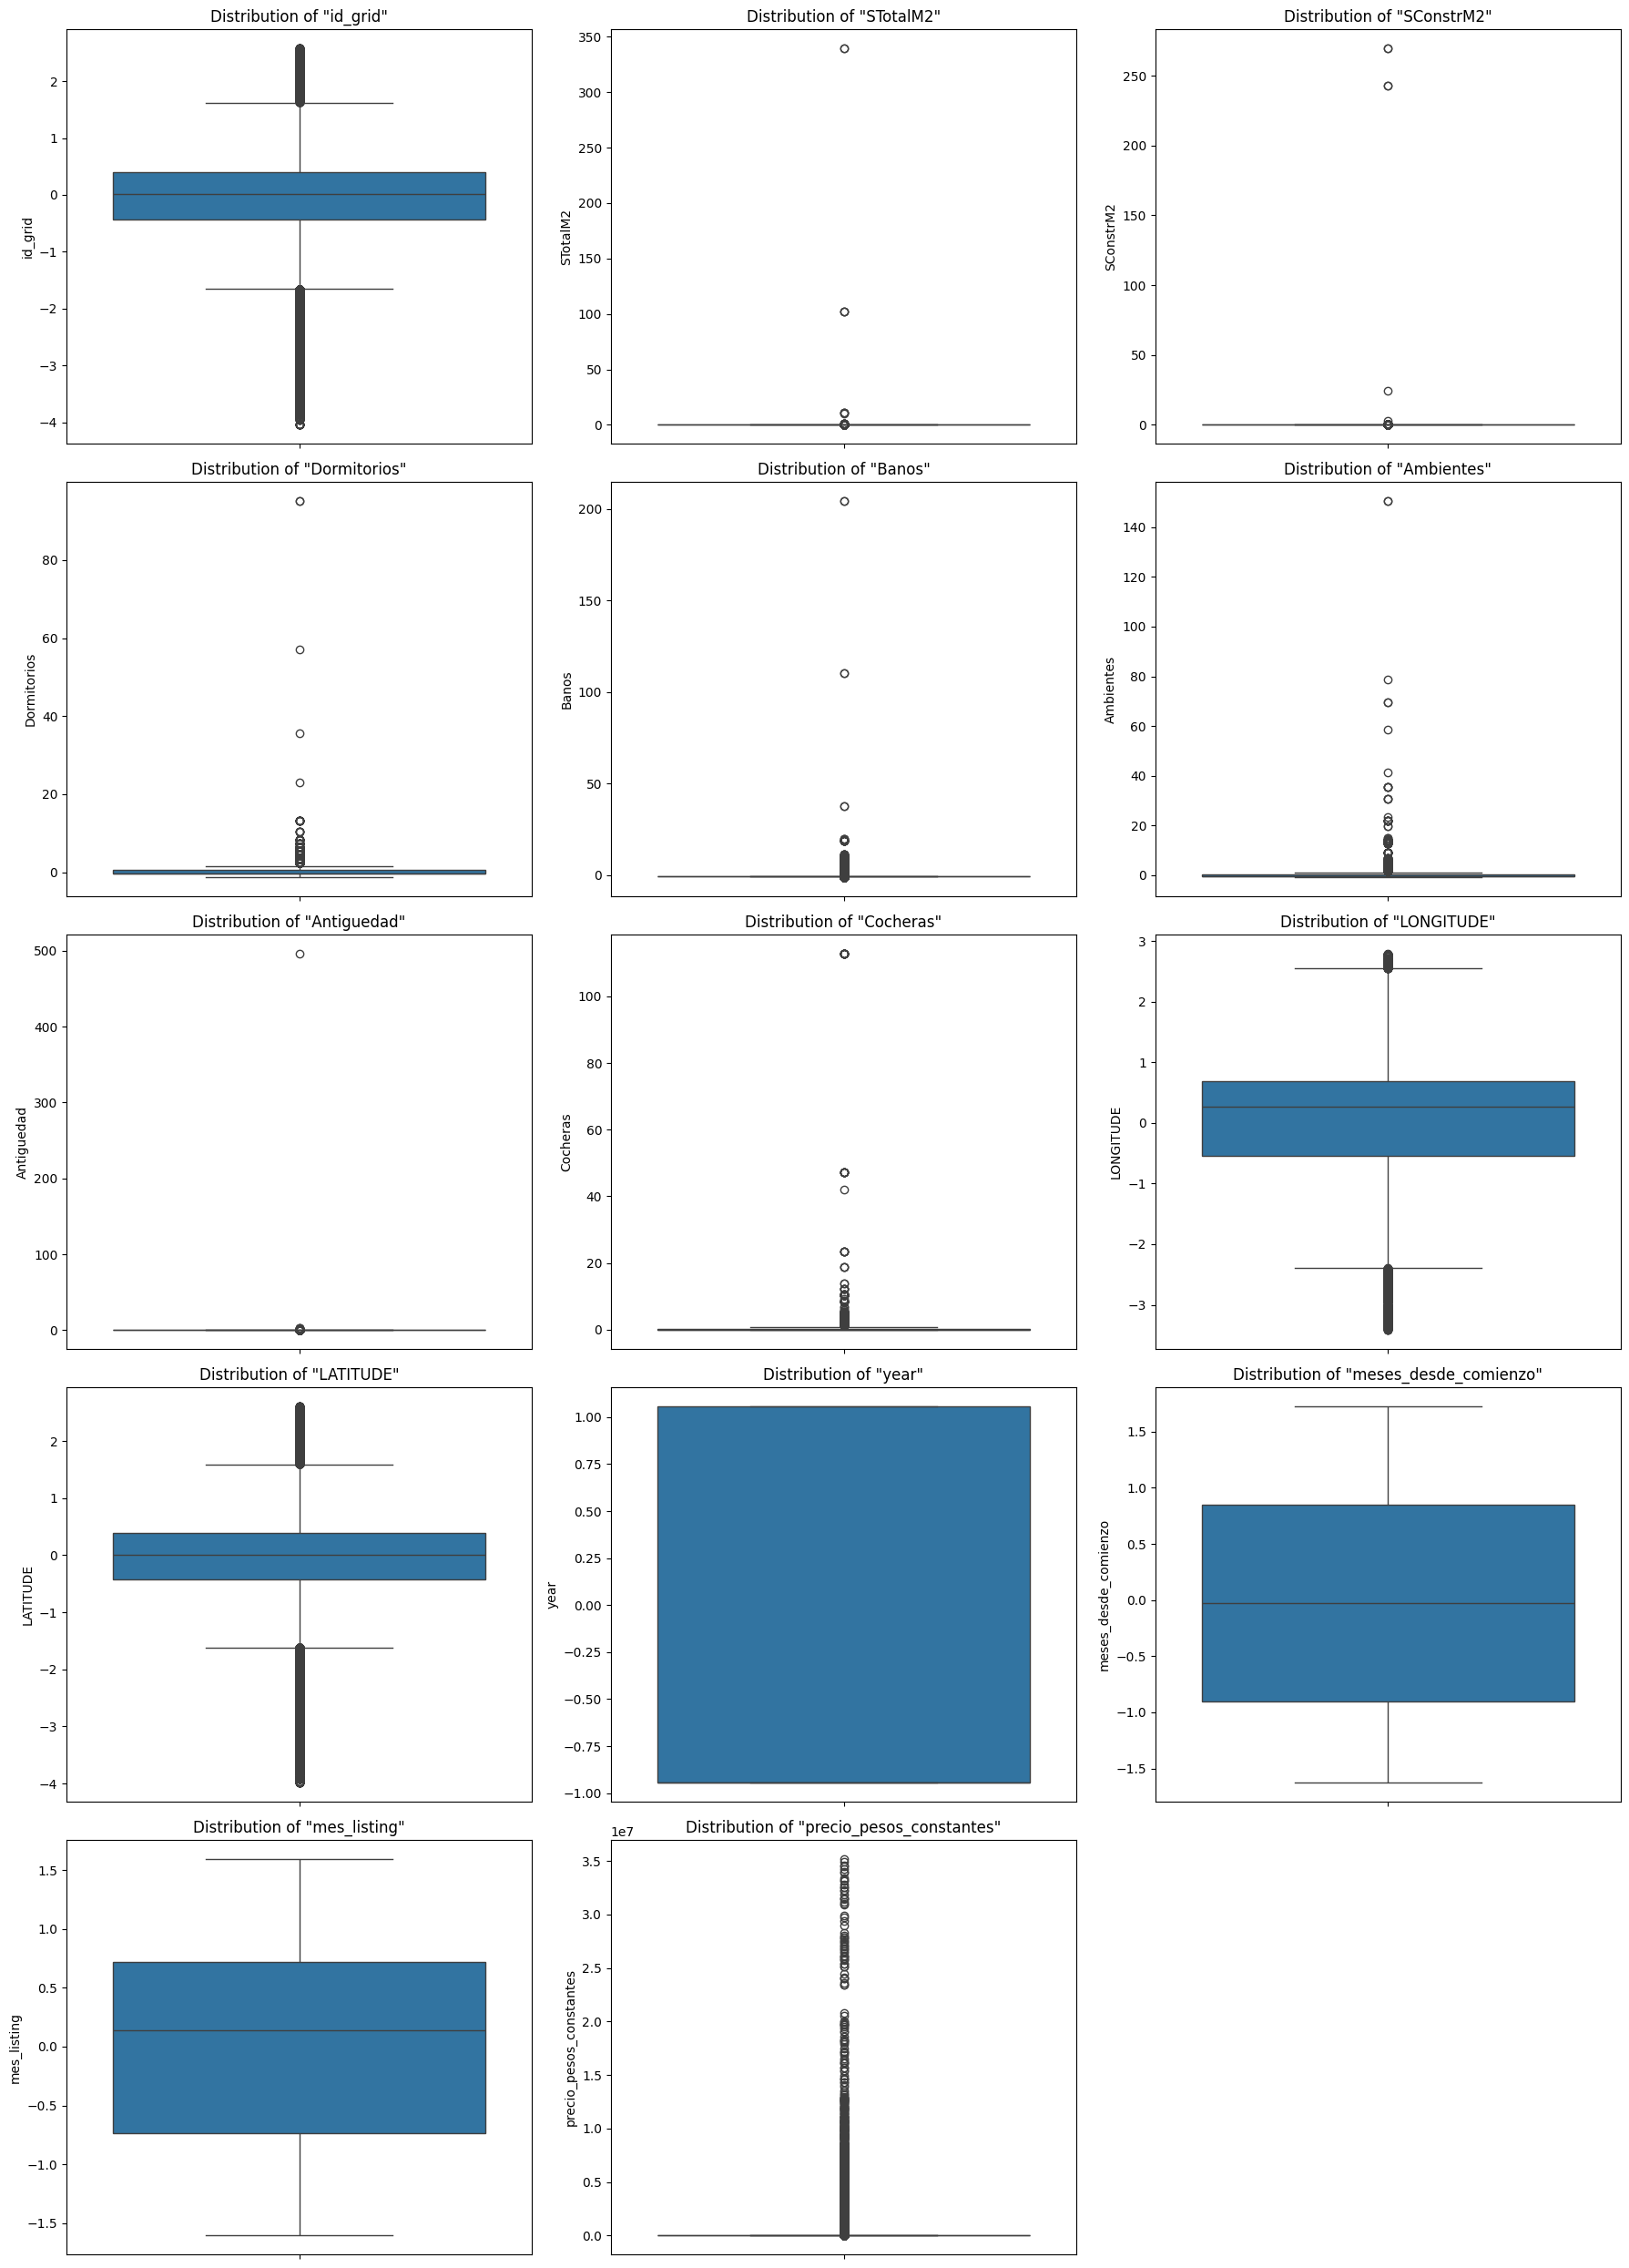

In [18]:
plot_boxplots(df_std, NUMERIC_COLS)

En la mayoría de features, la cantidad de outliers es extrema.